In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss
and make updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a `torch.*Tensor`.

-   For images, packages such as Pillow, OpenCV are useful
-   For audio, packages such as scipy and librosa
-   For text, either raw Python or Cython based loading, or NLTK and
    SpaCy are useful

Specifically for vision, we have created a package called `torchvision`,
that has data loaders for common datasets such as ImageNet, CIFAR10,
MNIST, etc. and data transformers for images, viz.,
`torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes:
'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
'ship', 'truck'. The images in CIFAR-10 are of size 3x32x32, i.e.
3-channel color images of 32x32 pixels in size.

![cifar10](https://pytorch.org/tutorials/_static/img/cifar10.png)

Training an image classifier
----------------------------

We will do the following steps in order:

1.  Load and normalize the CIFAR10 training and test datasets using
    `torchvision`
2.  Define a Convolutional Neural Network
3.  Define a loss function
4.  Train the network on the training data
5.  Test the network on the test data

### 1. Load and normalize CIFAR10

Using `torchvision`, it's extremely easy to load CIFAR10.


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range \[0,
1\]. We transform them to Tensors of normalized range \[-1, 1\].


<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>If running on Windows and you get a BrokenPipeError, try settingthe num_worker of torch.utils.data.DataLoader() to 0.</p>

</div>



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let us show some of the training images, for fun.


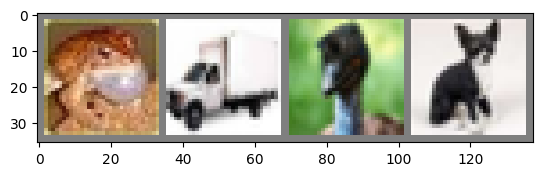

frog  truck bird  dog  


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

2. Define a Convolutional Neural Network
========================================

Copy the neural network from the Neural Networks section before and
modify it to take 3-channel images (instead of 1-channel images as it
was defined).


In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [7]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
from torchsummary import summary

In [9]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


3. Define a Loss function and optimizer
=======================================

Let\'s use a Classification Cross-Entropy loss and SGD with momentum.


In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
====================

This is when things start to get interesting. We simply have to loop
over our data iterator, and feed the inputs to the network and optimize.


In [11]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.241
[1,  4000] loss: 1.875
[1,  6000] loss: 1.691
[1,  8000] loss: 1.579
[1, 10000] loss: 1.506
[1, 12000] loss: 1.461
[2,  2000] loss: 1.382
[2,  4000] loss: 1.380
[2,  6000] loss: 1.353
[2,  8000] loss: 1.322
[2, 10000] loss: 1.285
[2, 12000] loss: 1.261
Finished Training


Let\'s quickly save our trained model:


In [12]:
PATH = './cifar_net.pth'

In [13]:
torch.save(net.state_dict(), PATH)

See [here](https://pytorch.org/docs/stable/notes/serialization.html) for
more details on saving PyTorch models.

5. Test the network on the test data
====================================

We have trained the network for 2 passes over the training dataset. But
we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get
familiar.


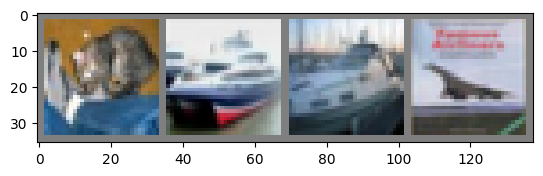

GroundTruth:  cat   ship  ship  plane


In [14]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let\'s load back in our saved model (note: saving and re-loading
the model wasn\'t necessary here, we only did it to illustrate how to do
so):


In [15]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above
are:


In [16]:
outputs = net(images)
print("raw outputs: ", outputs)

raw outputs:  tensor([[ 0.1042, -1.7567,  1.1002,  1.2124,  0.3301,  0.9343,  0.6957, -1.4338,
          0.4106, -1.5264],
        [ 4.5659,  7.8026, -2.6410, -3.4850, -4.0708, -5.7817, -4.6217, -5.4090,
          6.4516,  5.3810],
        [ 1.8511,  2.8084, -0.6770, -1.1122, -1.8910, -1.8732, -2.7062, -1.9980,
          2.1067,  2.4154],
        [ 5.0406,  0.8121,  1.0492, -1.3081,  0.2672, -3.6553, -2.3678, -3.1843,
          3.0843, -0.0588]], grad_fn=<AddmmBackward0>)


The outputs are energies for the 10 classes. The higher the energy for a
class, the more the network thinks that the image is of the particular
class. So, let\'s get the index of the highest energy:


In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   car   plane


In [18]:
# get image numpy
images_np = images.cpu().detach().numpy()
images_np, images_np.shape

(array([[[[ 0.23921573,  0.24705887,  0.2941177 , ...,  0.07450986,
           -0.01176471, -0.09019607],
          [ 0.19215691,  0.18431377,  0.24705887, ...,  0.06666672,
           -0.01960784, -0.06666666],
          [ 0.18431377,  0.18431377,  0.23921573, ...,  0.09019613,
            0.0196079 , -0.05882353],
          ...,
          [-0.46666664, -0.67058825, -0.75686276, ..., -0.7019608 ,
           -0.8980392 , -0.6862745 ],
          [-0.52156866, -0.6156863 , -0.7254902 , ..., -0.79607844,
           -0.77254903, -0.84313726],
          [-0.5764706 , -0.56078434, -0.64705884, ..., -0.8117647 ,
           -0.73333335, -0.8352941 ]],
 
         [[-0.12156862, -0.12941176, -0.09019607, ..., -0.25490195,
           -0.2862745 , -0.3333333 ],
          [-0.12156862, -0.1372549 , -0.10588235, ..., -0.25490195,
           -0.2862745 , -0.3098039 ],
          [-0.1372549 , -0.14509803, -0.12941176, ..., -0.23137254,
           -0.25490195, -0.30196077],
          ...,
          [-0

The results seem pretty good.

Let us look at how the network performs on the whole dataset.


In [19]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


That looks way better than chance, which is 10% accuracy (randomly
picking a class out of 10 classes). Seems like the network learnt
something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:


In [20]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 65.2 %
Accuracy for class: car   is 65.3 %
Accuracy for class: bird  is 33.1 %
Accuracy for class: cat   is 39.8 %
Accuracy for class: deer  is 54.4 %
Accuracy for class: dog   is 52.4 %
Accuracy for class: frog  is 68.1 %
Accuracy for class: horse is 53.6 %
Accuracy for class: ship  is 70.5 %
Accuracy for class: truck is 61.1 %


Training on multiple GPUs
=========================

If you want to see even more MASSIVE speedup using all of your GPUs,
please check out `data_parallel_tutorial`{.interpreted-text role="doc"}.

Where do I go next?
===================

-   `Train neural nets to play video games </intermediate/reinforcement_q_learning>`{.interpreted-text
    role="doc"}
-   [Train a state-of-the-art ResNet network on
    imagenet](https://github.com/pytorch/examples/tree/master/imagenet)
-   [Train a face generator using Generative Adversarial
    Networks](https://github.com/pytorch/examples/tree/master/dcgan)
-   [Train a word-level language model using Recurrent LSTM
    networks](https://github.com/pytorch/examples/tree/master/word_language_model)
-   [More examples](https://github.com/pytorch/examples)
-   [More tutorials](https://github.com/pytorch/tutorials)
-   [Discuss PyTorch on the Forums](https://discuss.pytorch.org/)
-   [Chat with other users on
    Slack](https://pytorch.slack.com/messages/beginner/)


In [21]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import numpy as np

In [22]:
class Net_TF(tf.keras.Model):
    def __init__(self):
        super(Net_TF, self).__init__()
        self.conv1 = layers.Conv2D(6, (5, 5), activation='relu', input_shape=(None, None, 3))
        self.pool = layers.MaxPooling2D((2, 2))
        self.conv2 = layers.Conv2D(16, (5, 5), activation='relu')
        self.flat = layers.Flatten()
        self.fc1 = layers.Dense(120, activation='relu')
        self.fc2 = layers.Dense(84, activation='relu')
        self.fc3 = layers.Dense(10)

    def call(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.flat(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


In [23]:
net_tf = Net_TF()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
input_data = tf.random.uniform((1, 32, 32, 3))
net_tf(input_data)
net_tf.summary()

Model: "net_tf"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (1, 28, 28, 6)         │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (1, 10, 10, 16)        │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (1, 400)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 120)               │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 84)                │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 10)                │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,006 (242.21 KB)

 Trainable params: 62,006 (242.21 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
type(net.conv1), type(net.fc1)

(torch.nn.modules.conv.Conv2d, torch.nn.modules.linear.Linear)

In [26]:
net.conv1.weight.cpu().detach().numpy().shape

(6, 3, 5, 5)

In [27]:
%ls

cifar_net.pth  example.py    sample_data/
data/          __pycache__/  torch_tf_convert.py


In [28]:
## clone then import
## test our github codes
!git clone https://github.com/KuoYuChang/Torch2TF_Weight_Convert.git

Cloning into 'Torch2TF_Weight_Convert'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22 (delta 10), reused 16 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 6.81 KiB | 6.81 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [29]:
%cd Torch2TF_Weight_Convert

/content/Torch2TF_Weight_Convert


In [30]:
!ls

example.py  LICENSE  README.md	torch_tf_convert.py


In [31]:
from torch_tf_convert import convert

In [32]:
## run function

torch_list = []
tf_list = []
shape_list = []


# manually fill-in

torch_list.append(net.conv1)
torch_list.append(net.conv2)
torch_list.append(net.fc1)
torch_list.append(net.fc2)
torch_list.append(net.fc3)

tf_list.append(net_tf.conv1)
tf_list.append(net_tf.conv2)
tf_list.append(net_tf.fc1)
tf_list.append(net_tf.fc2)
tf_list.append(net_tf.fc3)

shape_list.append(None)
shape_list.append(None)
# shape before first linear
shape_list.append((16, 5, 5))
shape_list.append(None)
shape_list.append(None)

assert len(torch_list) == len(tf_list), "number of torch layers in model must same as tensorflow layers in one"

In [33]:
convert(torch_list, tf_list, shape_list)

## test on image np

In [34]:
images_np.shape

(4, 3, 32, 32)

### remember to transpose tensorflow tensor

In [35]:
images_tf = tf.convert_to_tensor(images_np)
images_tf = tf.transpose(images_tf, perm=[0, 2, 3, 1])
images_tf.shape

TensorShape([4, 32, 32, 3])

In [36]:
net_tf(images_tf)

<tf.Tensor: shape=(4, 10), dtype=float32, numpy=
array([[ 0.10419862, -1.7567439 ,  1.1001837 ,  1.2124122 ,  0.3301375 ,
         0.93434715,  0.6956738 , -1.4337883 ,  0.41059154, -1.5264246 ],
       [ 4.565901  ,  7.802559  , -2.6409743 , -3.485004  , -4.0708365 ,
        -5.781728  , -4.6216655 , -5.4089665 ,  6.451631  ,  5.380965  ],
       [ 1.8510832 ,  2.808384  , -0.67704403, -1.1121664 , -1.8909726 ,
        -1.8732212 , -2.7061644 , -1.997993  ,  2.106695  ,  2.4154139 ],
       [ 5.040604  ,  0.8120575 ,  1.0492272 , -1.3081079 ,  0.26716858,
        -3.6552901 , -2.3677783 , -3.184319  ,  3.0842912 , -0.05883393]],
      dtype=float32)>

## test cifar10 in Tensorflow

In [37]:
from tensorflow.keras import datasets

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


In [38]:
# preprocessing
train_images, test_images = train_images / 255.0, test_images / 255.0
tf_normal = tf.keras.layers.Normalization(mean=(0.5, 0.5, 0.5), variance=(0.5**2, 0.5**2, 0.5**2))
test_images = tf_normal(test_images)

In [39]:
net_tf.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
test_loss, test_acc = net_tf.evaluate(test_images,  test_labels, verbose=2)

313/313 - 2s - 7ms/step - accuracy: 0.5635 - loss: 1.2254


## References
### torch training a classifier
https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html